In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'SVHN_1x64x64_train.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    del save  # hint to help gc free up memory
    print('train set', train_dataset.shape, train_labels.shape)

train set (97722, 1, 64, 64) (97722, 6)


In [3]:
pickle_file = 'SVHN_1x64x64_valid.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('valis set', valid_dataset.shape, valid_labels.shape)

valis set (5679, 1, 64, 64) (5679, 6)


In [3]:
c5 = []

for i in range(5679):
    categ = valid_labels[i][0]
    if(categ == 5):
        c5.append(i)

print(len(c5))

52


In [4]:
c5_data = train_dataset[c5]
c5_target = train_labels[c5]
print(c5_data.shape)
print(c5_target.shape)

(52, 1, 64, 64)
(52, 6)


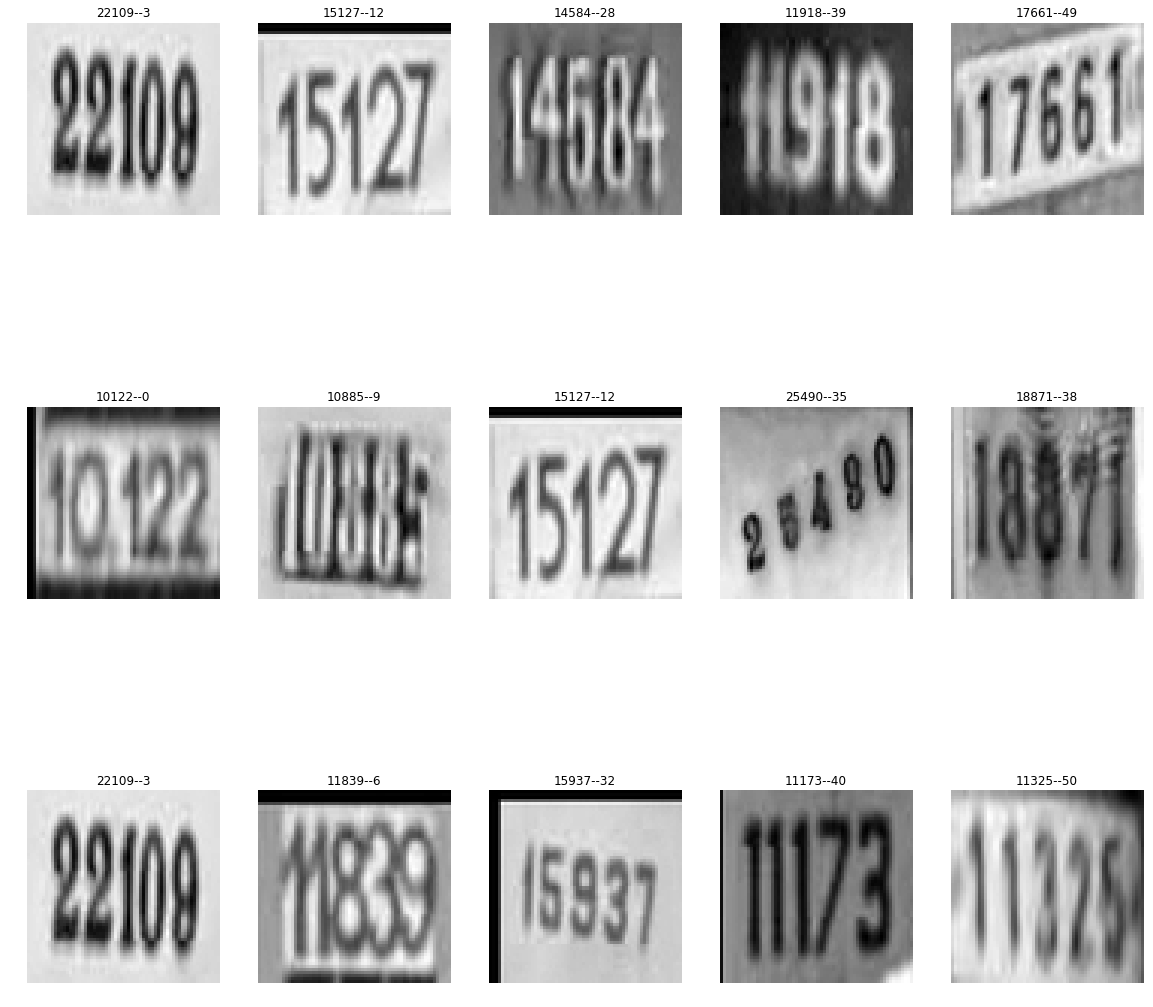

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=3, ncols=5)

im_samples = []

for row in range(3):
    for i, j in enumerate(np.sort(np.random.randint(0, c5_target.shape[0], size=5))):
        im = c5_data[j].reshape((64, 64, 1))
        house_num = ''
        for k in np.arange(c5_target[j,0]):
            house_num += str(c5_target[j,k+1])
        house_num += "--" + str(j)
        im_samples.extend([j])
        ax[row, i].axis('off')
        ax[row, i].set_title(house_num, loc='center')
        ax[row, i].imshow(im[:,:,0], cmap='gray')

[5 1 1 3 2 5]


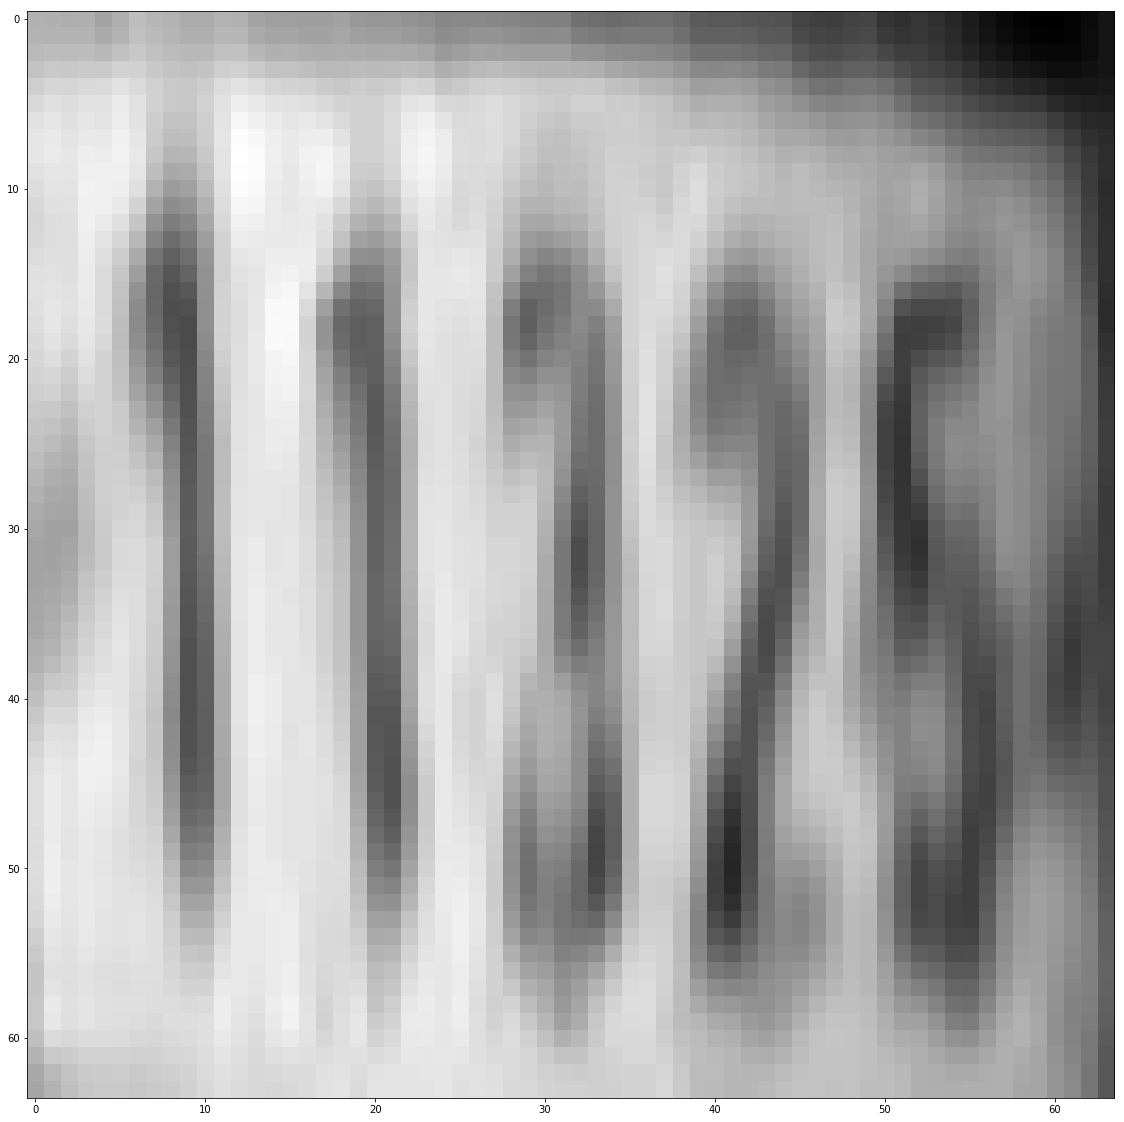

In [6]:
plt.imshow(c5_data[50].reshape(64, 64), cmap='gray')
print(c5_target[50])

In [7]:
a = (44, 46, 47, 46, 37, 48, 40, 42, 49, 38, 39, 41, 43, 45)

In [8]:
c5_data = np.delete(c5_data, a, axis=0)
print(c5_data.shape)

(39, 1, 64, 64)


In [9]:
c5_target = np.delete(c5_target, a, axis=0)
print(c5_target.shape)

(39, 6)


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, padding=(1, 1))
        self.conv2 = nn.Conv2d(20, 40, 3, padding=(1, 1))
        self.conv3 = nn.Conv2d(40, 80, 3, padding=(1, 1))
        self.conv4 = nn.Conv2d(80, 120, 3, padding=(1, 1))
        self.conv5 = nn.Conv2d(120, 160, 3, padding=(1, 1))
        self.conv6 = nn.Conv2d(160, 200, 3, padding=(1, 1))
        self.conv7 = nn.Conv2d(200, 240, 3, padding=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.drop2d = nn.Dropout2d(0.25)
        self.drop1 = nn.Dropout(0.35)
        self.drop2 = nn.Dropout(0.5)
        self.bnorm1 = nn.BatchNorm2d(80)
        self.bnorm2 = nn.BatchNorm2d(120)
        self.bnorm3 = nn.BatchNorm2d(160)
        self.bnorm4 = nn.BatchNorm2d(200)
        self.bnorm5 = nn.BatchNorm2d(240)
        self.FC = nn.Linear(960, 1080)
        self.digitlength = nn.Linear(1080, 7)
        self.digit1 = nn.Linear(1080, 10)
        self.digit2 = nn.Linear(1080, 10)
        self.digit3 = nn.Linear(1080, 10)
        self.digit4 = nn.Linear(1080, 10)
        self.digit5 = nn.Linear(1080, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop2d(x)
        x = self.bnorm1(F.relu(self.conv3(x)))
        x = self.pool(self.bnorm2(F.relu(self.conv4(x))))
        x = self.drop1(x)
        x = self.pool(self.bnorm3(F.relu(self.conv5(x))))
        x = self.drop1(x)
        x = self.pool(self.bnorm4(F.relu(self.conv6(x))))
        x = self.drop1(x)
        x = self.pool(self.bnorm5(F.relu(self.conv7(x))))
        x = x.view(-1, 960)
        x = self.drop1(x)
        x = F.relu(self.FC(x))
        x = self.drop2(x)
        yl = self.digitlength(x)
        y1 = self.digit1(x)
        y2 = self.digit2(x)
        y3 = self.digit3(x)
        y4 = self.digit4(x)
        y5 = self.digit5(x)
        return [yl, y1, y2, y3, y4, y5]

In [11]:
net = Net()
net.cuda()

Net (
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(80, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(120, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(160, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(200, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (drop2d): Dropout2d (p=0.25)
  (drop1): Dropout (p = 0.35)
  (drop2): Dropout (p = 0.5)
  (bnorm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (bnorm2): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True)
  (bnorm3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
  (bnorm4): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
  (bnorm5): BatchNorm2d(24

In [12]:
for param in net.parameters():
    if(param.grad is not None):
        print(param)

In [13]:
c5_data_tensor = torch.from_numpy(c5_data)
c5_target_tensor = torch.from_numpy(c5_target).type(torch.LongTensor)
print(c5_data_tensor.type(), c5_data_tensor.size())
print(c5_target_tensor.type(), c5_target_tensor.size())

torch.FloatTensor torch.Size([39, 1, 64, 64])
torch.LongTensor torch.Size([39, 6])


In [14]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [20]:
num_epochs = 200
batch_size = 5
num_train =  c5_data.shape[0]
iter_per_epoch = num_train // batch_size
print_every = 3
print(iter_per_epoch)

7


In [21]:
epoch_losses = {i:[] for i in range(num_epochs)}
loss_history = []

In [22]:
import time

In [24]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 110)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        
        if phase == 'train':
            net.train(True)  # Set model to training mode
            print("train phase")
        else:
            net.train(False)  # Set model to evaluate mode
            print("evaluate phase")

        i = 0
        rng_state = torch.get_rng_state()
        new_idxs = torch.randperm(num_train)
        c5_X = c5_data_tensor[new_idxs]
        c5_Y = c5_target_tensor[new_idxs]

        t1 = time.time()
        for t in range(iter_per_epoch):

            X_batch = c5_X[i: i+batch_size]
            Y_batch = c5_Y[i: i+batch_size]
            i += batch_size

            Y_batch = Variable(Y_batch.cuda())
            X_batch = Variable(X_batch.cuda())

            optimizer.zero_grad()

            outputs = net(X_batch)

            lossl = objective(outputs[0], Y_batch[:, 0])
            loss1 = objective(outputs[1], Y_batch[:, 1])
            loss2 = objective(outputs[2], Y_batch[:, 2])
            loss3 = objective(outputs[3], Y_batch[:, 3])
            loss4 = objective(outputs[4], Y_batch[:, 4])
            loss5 = objective(outputs[5], Y_batch[:, 5])
            final_loss = lossl + loss1 + loss2 + loss3 + loss4 + loss5
            
            if phase == 'train':
                final_loss.backward()
                optimizer.step()

            loss_history.append(final_loss.data[0])
            epoch_losses[epoch].append(final_loss.data[0])

            if (t % print_every == 0):
                print('Iteration : ', t+1, ' / ', iter_per_epoch)
                print('loss : ', final_loss.data[0])
                print('lossl : ', lossl.data[0], 'loss1 : ', loss1.data[0], 'loss2 : ', loss2.data[0], 'loss3 : ', loss3.data[0])
                print('loss4 : ', loss4.data[0], 'loss5 : ', loss5.data[0])
        t2 = time.time()
        print("time taken : ", t2-t1)
        print('-' * 110)


Epoch 0/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.09526059031486511
lossl :  1.9073486612342094e-07 loss1 :  0.007006215862929821 loss2 :  0.024568915367126465 loss3 :  0.04151954501867294
loss4 :  0.0038614273071289062 loss5 :  0.01830429956316948
Iteration :  4  /  7
loss :  0.053737640380859375
lossl :  6.771087555534905e-06 loss1 :  0.001122808433137834 loss2 :  0.011043453589081764 loss3 :  0.02669849433004856
loss4 :  0.00892419833689928 loss5 :  0.005941915325820446
Iteration :  7  /  7
loss :  0.24038276076316833
lossl :  5.245208740234375e-06 loss1 :  0.0028625489212572575 loss2 :  0.07855310291051865 loss3 :  0.11320038139820099
loss4 :  0.006161498837172985 loss5 :  0.03959999233484268
time taken :  0.5777287483215332
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  

Iteration :  1  /  7
loss :  0.2785864472389221
lossl :  8.239746239269152e-05 loss1 :  0.03712492063641548 loss2 :  0.05167841911315918 loss3 :  0.1662839949131012
loss4 :  0.012023639865219593 loss5 :  0.011393070220947266
Iteration :  4  /  7
loss :  0.025372648611664772
lossl :  0.0 loss1 :  0.00019006729417014867 loss2 :  0.004047823138535023 loss3 :  0.0012458801502361894
loss4 :  0.01550588570535183 loss5 :  0.004382991697639227
Iteration :  7  /  7
loss :  0.09936802834272385
lossl :  0.0 loss1 :  0.0004119873046875 loss2 :  0.02149968221783638 loss3 :  0.06947801262140274
loss4 :  0.0046714781783521175 loss5 :  0.003306865692138672
time taken :  0.5628292560577393
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.06477232277393341
lossl :  0.0 loss1 :  0.0013821125030517578 loss2 :  0.028089141473174095 loss3 :  0.005284452345222235
loss4 :  0.00955190695822239 loss5 :  0

lossl :  4.76837158203125e-07 loss1 :  0.1136503666639328 loss2 :  0.06520514190196991 loss3 :  0.19937406480312347
loss4 :  0.2679515480995178 loss5 :  0.6341358423233032
time taken :  0.19089484214782715
--------------------------------------------------------------------------------------------------------------
Epoch 10/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.23324967920780182
lossl :  1.9073486612342094e-07 loss1 :  0.03816509246826172 loss2 :  0.13515286147594452 loss3 :  0.003724002745002508
loss4 :  0.016074324026703835 loss5 :  0.04013318940997124
Iteration :  4  /  7
loss :  0.09367118030786514
lossl :  0.0 loss1 :  0.0011501312255859375 loss2 :  0.02588520012795925 loss3 :  0.004542016889899969
loss4 :  0.0013545036781579256 loss5 :  0.06073932722210884
Iteration :  7  /  7
loss :  0.012548064813017845
lossl :  0.0 loss1 :  8.00132766016759e-05 loss2 :  0.000

Iteration :  1  /  7
loss :  0.3138340413570404
lossl :  0.0 loss1 :  0.005885315127670765 loss2 :  0.009159088134765625 loss3 :  0.04546480253338814
loss4 :  0.2212606966495514 loss5 :  0.032064151018857956
Iteration :  4  /  7
loss :  0.03135061264038086
lossl :  3.814697322468419e-07 loss1 :  0.0006479740259237587 loss2 :  0.021342705935239792 loss3 :  0.0005863189580850303
loss4 :  0.0018644332885742188 loss5 :  0.00690879812464118
Iteration :  7  /  7
loss :  0.25793635845184326
lossl :  1.9073486612342094e-07 loss1 :  0.002698564436286688 loss2 :  0.11238918453454971 loss3 :  0.02392401732504368
loss4 :  0.040844012051820755 loss5 :  0.07808039337396622
time taken :  0.5683996677398682
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.08751005679368973
lossl :  0.0 loss1 :  0.00294075021520257 loss2 :  0.04741325229406357 loss3 :  0.003899478819221258
loss4 :  0.008358287625

Iteration :  1  /  7
loss :  0.07947015762329102
lossl :  1.3351440202313825e-06 loss1 :  0.0002993583620991558 loss2 :  0.019158268347382545 loss3 :  0.04110908508300781
loss4 :  0.01092996634542942 loss5 :  0.007972145453095436
Iteration :  4  /  7
loss :  0.038224101066589355
lossl :  0.0 loss1 :  0.021729469299316406 loss2 :  0.0013455391163006425 loss3 :  0.0022389411460608244
loss4 :  0.012038493528962135 loss5 :  0.0008716583251953125
Iteration :  7  /  7
loss :  0.04247903451323509
lossl :  2.956390289909905e-06 loss1 :  0.001947689102962613 loss2 :  0.012584495358169079 loss3 :  0.018831919878721237
loss4 :  0.00018396376981399953 loss5 :  0.008928013034164906
time taken :  0.5593047142028809
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.1642247885465622
lossl :  1.9073486612342094e-07 loss1 :  0.001256752060726285 loss2 :  0.14910265803337097 loss3 :  0.0008154868846

Iteration :  1  /  7
loss :  0.00953969918191433
lossl :  0.0 loss1 :  0.0001585006684763357 loss2 :  0.0006614684825763106 loss3 :  0.0005465507274493575
loss4 :  0.00439839344471693 loss5 :  0.003774785902351141
Iteration :  4  /  7
loss :  0.13096052408218384
lossl :  0.0 loss1 :  0.0005167961353436112 loss2 :  0.0154334781691432 loss3 :  0.009102916345000267
loss4 :  0.0063779354095458984 loss5 :  0.09952940791845322
Iteration :  7  /  7
loss :  0.05053424835205078
lossl :  0.0 loss1 :  0.0011906623840332031 loss2 :  0.007166385650634766 loss3 :  0.012991237454116344
loss4 :  0.027358055114746094 loss5 :  0.0018279075156897306
time taken :  0.5698399543762207
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  3.458674669265747
lossl :  4.76837158203125e-07 loss1 :  0.0012532233959063888 loss2 :  1.2083921432495117 loss3 :  0.6292517781257629
loss4 :  1.2822266817092896 loss5 :  0

Iteration :  1  /  7
loss :  0.01306614838540554
lossl :  1.144409225162235e-06 loss1 :  0.0012265205150470138 loss2 :  0.008418416604399681 loss3 :  0.0011358261108398438
loss4 :  0.00045680999755859375 loss5 :  0.0018274306785315275
Iteration :  4  /  7
loss :  0.008086776360869408
lossl :  0.0 loss1 :  0.00014009475125931203 loss2 :  0.004388236906379461 loss3 :  0.0009034156682901084
loss4 :  0.00169963832013309 loss5 :  0.0009553909185342491
Iteration :  7  /  7
loss :  0.2894834578037262
lossl :  0.0 loss1 :  0.14995737373828888 loss2 :  0.013666200451552868 loss3 :  0.0952790230512619
loss4 :  0.012738848105072975 loss5 :  0.01784200593829155
time taken :  0.5803463459014893
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.03610701486468315
lossl :  0.0 loss1 :  0.01135926228016615 loss2 :  0.002784633543342352 loss3 :  0.01245412789285183
loss4 :  0.0029172897338867188 lo

Iteration :  1  /  7
loss :  0.25597167015075684
lossl :  1.9073486612342094e-07 loss1 :  0.0010533332824707031 loss2 :  0.010226964950561523 loss3 :  0.005529451183974743
loss4 :  0.01721477508544922 loss5 :  0.22194695472717285
Iteration :  4  /  7
loss :  2.8156306743621826
lossl :  1.23977656585339e-06 loss1 :  0.10782794654369354 loss2 :  0.5263739824295044 loss3 :  0.40501099824905396
loss4 :  0.8929437398910522 loss5 :  0.8834728002548218
Iteration :  7  /  7
loss :  0.030485104769468307
lossl :  1.9073486612342094e-07 loss1 :  0.0004105567932128906 loss2 :  0.0035174370277673006 loss3 :  0.016591167077422142
loss4 :  0.006120014004409313 loss5 :  0.003845739411190152
time taken :  0.5806643962860107
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.1603911966085434
lossl :  0.0 loss1 :  0.0032209395430982113 loss2 :  0.06097093224525452 loss3 :  0.027100944891572
loss4 :  

Iteration :  1  /  7
loss :  0.16491812467575073
lossl :  5.722046125811175e-07 loss1 :  0.06231100484728813 loss2 :  0.005453777499496937 loss3 :  0.0031162737868726254
loss4 :  0.015788841992616653 loss5 :  0.07824764400720596
Iteration :  4  /  7
loss :  0.07526931911706924
lossl :  0.0 loss1 :  0.012432861141860485 loss2 :  0.03965292125940323 loss3 :  0.003006076905876398
loss4 :  0.019957637414336205 loss5 :  0.00021982192993164062
Iteration :  7  /  7
loss :  0.1410176306962967
lossl :  5.245208740234375e-06 loss1 :  0.003907537553459406 loss2 :  0.03161430358886719 loss3 :  0.029407262802124023
loss4 :  0.06423673778772354 loss5 :  0.011846542358398438
time taken :  0.5611250400543213
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.004621696658432484
lossl :  0.0 loss1 :  0.0008978843688964844 loss2 :  0.0007164001581259072 loss3 :  0.0012067795032635331
loss4 :  0.00057

Iteration :  1  /  7
loss :  0.020109940320253372
lossl :  1.9073486612342094e-07 loss1 :  0.00016622543625999242 loss2 :  0.0020126341842114925 loss3 :  0.004715061280876398
loss4 :  0.010553980246186256 loss5 :  0.0026618479751050472
Iteration :  4  /  7
loss :  0.18182209134101868
lossl :  0.0003372192441020161 loss1 :  0.00061712262686342 loss2 :  0.04934690147638321 loss3 :  0.014953422360122204
loss4 :  0.05969667434692383 loss5 :  0.05687074735760689
Iteration :  7  /  7
loss :  0.11225690692663193
lossl :  1.9073486612342094e-07 loss1 :  0.013398027047514915 loss2 :  0.08661971241235733 loss3 :  0.007221317384392023
loss4 :  0.004527091979980469 loss5 :  0.0004905700916424394
time taken :  0.5639925003051758
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.4100923538208008
lossl :  0.0 loss1 :  0.043466757982969284 loss2 :  0.052877046167850494 loss3 :  0.0530149452388286

Iteration :  1  /  7
loss :  0.003501319792121649
lossl :  5.722046125811175e-07 loss1 :  0.0008079528925009072 loss2 :  0.00030260084895417094 loss3 :  0.00046367646427825093
loss4 :  0.0006361007690429688 loss5 :  0.0012904166942462325
Iteration :  4  /  7
loss :  0.018465280532836914
lossl :  1.9073486612342094e-07 loss1 :  0.00042591095552779734 loss2 :  0.0006734848138876259 loss3 :  0.004423809237778187
loss4 :  0.0024216175079345703 loss5 :  0.01052026730030775
Iteration :  7  /  7
loss :  0.01787109300494194
lossl :  0.0 loss1 :  0.002154827117919922 loss2 :  0.00880212802439928 loss3 :  0.0051513672806322575
loss4 :  0.0007340431329794228 loss5 :  0.0010287284385412931
time taken :  0.5859627723693848
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.22515809535980225
lossl :  0.0 loss1 :  0.02497110329568386 loss2 :  0.07889039814472198 loss3 :  0.03368673473596573
loss4

Iteration :  1  /  7
loss :  0.006318855565041304
lossl :  0.0 loss1 :  0.00016889572725631297 loss2 :  0.002412128495052457 loss3 :  0.001528835273347795
loss4 :  5.8841706049861386e-05 loss5 :  0.0021501542069017887
Iteration :  4  /  7
loss :  0.2821255922317505
lossl :  2.8610230629055877e-07 loss1 :  0.02469806745648384 loss2 :  0.14930228888988495 loss3 :  0.03463189676403999
loss4 :  0.05634868144989014 loss5 :  0.017144393175840378
Iteration :  7  /  7
loss :  0.011944914236664772
lossl :  0.0 loss1 :  0.0007241248968057334 loss2 :  0.001825523329898715 loss3 :  0.008814859203994274
loss4 :  6.237030174816027e-05 loss5 :  0.0005180359003134072
time taken :  0.5726559162139893
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0022791861556470394
lossl :  0.0 loss1 :  0.000888824462890625 loss2 :  0.00029115675715729594 loss3 :  0.0007953643798828125
loss4 :  0.0001041412324

Iteration :  1  /  7
loss :  0.2396230399608612
lossl :  0.0 loss1 :  0.014859771355986595 loss2 :  0.0014810562133789062 loss3 :  0.03637118265032768
loss4 :  0.016121482476592064 loss5 :  0.17078953981399536
Iteration :  4  /  7
loss :  0.010598374530673027
lossl :  9.536743306171047e-08 loss1 :  2.6798248654813506e-05 loss2 :  0.0038891793228685856 loss3 :  0.001264381455257535
loss4 :  0.001016330672428012 loss5 :  0.004401588346809149
Iteration :  7  /  7
loss :  0.015123939141631126
lossl :  3.814697322468419e-07 loss1 :  0.006561183836311102 loss2 :  0.0015905380714684725 loss3 :  0.0007377624278888106
loss4 :  0.005974292755126953 loss5 :  0.0002597808779682964
time taken :  0.5565814971923828
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  1.0251238346099854
lossl :  0.0 loss1 :  0.11747145652770996 loss2 :  0.0002929687616415322 loss3 :  0.09145407378673553
loss4 :  0.46

loss4 :  0.00013999939255882055 loss5 :  0.00031919480534270406
time taken :  0.18164515495300293
--------------------------------------------------------------------------------------------------------------
Epoch 65/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.07004842162132263
lossl :  3.814697322468419e-07 loss1 :  0.0024917603004723787 loss2 :  0.031273555010557175 loss3 :  0.018372725695371628
loss4 :  0.017595957964658737 loss5 :  0.00031404494075104594
Iteration :  4  /  7
loss :  0.030690716579556465
lossl :  0.0 loss1 :  3.719329833984375e-05 loss2 :  0.0258928295224905 loss3 :  0.00025644301786087453
loss4 :  0.004122591111809015 loss5 :  0.00038166047306731343
Iteration :  7  /  7
loss :  0.0009860038990154862
lossl :  0.0 loss1 :  0.0001108169526560232 loss2 :  1.506805438111769e-05 loss3 :  0.0007281303405761719
loss4 :  7.114410254871473e-05 loss5 :  6.0844420

Iteration :  1  /  7
loss :  0.0014245986239984632
lossl :  0.0 loss1 :  0.00042448044405318797 loss2 :  0.00011177062697242945 loss3 :  5.111694190418348e-05
loss4 :  0.0007529258728027344 loss5 :  8.430481102550402e-05
Iteration :  4  /  7
loss :  0.055332086980342865
lossl :  0.0 loss1 :  0.001321506453678012 loss2 :  0.019735049456357956 loss3 :  0.017871856689453125
loss4 :  0.009703731164336205 loss5 :  0.006699943449348211
Iteration :  7  /  7
loss :  0.02248668670654297
lossl :  0.0 loss1 :  0.0022471428383141756 loss2 :  0.01943521574139595 loss3 :  0.00028057099552825093
loss4 :  0.00040540695772506297 loss5 :  0.0001183509812108241
time taken :  0.560438871383667
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.7944373488426208
lossl :  0.0 loss1 :  8.525848534191027e-05 loss2 :  0.116075798869133 loss3 :  0.17494049668312073
loss4 :  0.5022468566894531 loss5 :  0.0010

Iteration :  1  /  7
loss :  0.011974764056503773
lossl :  0.0 loss1 :  0.0008565426105633378 loss2 :  0.0006666183471679688 loss3 :  0.0001107215866795741
loss4 :  0.007693481631577015 loss5 :  0.00264739990234375
Iteration :  4  /  7
loss :  0.029462339356541634
lossl :  0.0 loss1 :  0.02525930479168892 loss2 :  0.001386928604915738 loss3 :  0.0022673606872558594
loss4 :  0.00018739700317382812 loss5 :  0.00036134719266556203
Iteration :  7  /  7
loss :  0.007113838102668524
lossl :  0.0 loss1 :  0.0011684417258948088 loss2 :  0.0003455161931924522 loss3 :  0.0016643523704260588
loss4 :  0.0008737564203329384 loss5 :  0.0030617713928222656
time taken :  0.6088175773620605
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0032974244095385075
lossl :  2.8610230629055877e-07 loss1 :  0.0002787589910440147 loss2 :  0.00018320084200240672 loss3 :  0.0024345398414880037
loss4 :  0.000

Iteration :  1  /  7
loss :  0.030196644365787506
lossl :  0.0 loss1 :  4.463195728021674e-05 loss2 :  0.028658080846071243 loss3 :  0.0006814002990722656
loss4 :  0.0006422043079510331 loss5 :  0.00017032623873092234
Iteration :  4  /  7
loss :  0.010973453521728516
lossl :  0.0 loss1 :  6.933211989235133e-05 loss2 :  0.00030918122502043843 loss3 :  0.00920877419412136
loss4 :  0.0007156372303143144 loss5 :  0.00067052838858217
Iteration :  7  /  7
loss :  0.022020481526851654
lossl :  0.0 loss1 :  0.00024127960205078125 loss2 :  0.0036939620040357113 loss3 :  0.000888824462890625
loss4 :  0.007583522703498602 loss5 :  0.00961289368569851
time taken :  0.5585412979125977
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0037675858475267887
lossl :  0.0 loss1 :  8.726119995117188e-05 loss2 :  0.0006241798400878906 loss3 :  0.00019044875807594508
loss4 :  0.00016794205293990672 los

Iteration :  1  /  7
loss :  0.009513474069535732
lossl :  0.0 loss1 :  0.0014604568714275956 loss2 :  0.00013170242891646922 loss3 :  0.006550312042236328
loss4 :  0.00017232894606422633 loss5 :  0.00119867327157408
Iteration :  4  /  7
loss :  0.07515764236450195
lossl :  7.629394644936838e-07 loss1 :  8.392333984375e-05 loss2 :  0.001260471297428012 loss3 :  0.0008541106944903731
loss4 :  0.0683535560965538 loss5 :  0.004604816436767578
Iteration :  7  /  7
loss :  0.023143863305449486
lossl :  1.9073486612342094e-07 loss1 :  0.0012729645241051912 loss2 :  0.001367855118587613 loss3 :  0.006429624743759632
loss4 :  0.011223554611206055 loss5 :  0.002849674317985773
time taken :  0.5677721500396729
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.024521352723240852
lossl :  1.5258789289873675e-06 loss1 :  0.00079259870108217 loss2 :  0.002821254776790738 loss3 :  0.005077552981

Iteration :  7  /  7
loss :  0.19440770149230957
lossl :  1.9073486612342094e-07 loss1 :  0.02377314493060112 loss2 :  0.052590180188417435 loss3 :  0.014050960540771484
loss4 :  0.10206727683544159 loss5 :  0.0019259452819824219
time taken :  0.200819730758667
--------------------------------------------------------------------------------------------------------------
Epoch 90/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.001796626951545477
lossl :  0.0 loss1 :  0.00029077529325149953 loss2 :  0.00016307830810546875 loss3 :  2.937316821771674e-05
loss4 :  0.0010597228538244963 loss5 :  0.0002536773681640625
Iteration :  4  /  7
loss :  0.12100858986377716
lossl :  0.0 loss1 :  0.0978008285164833 loss2 :  0.0017671107780188322 loss3 :  0.019796038046479225
loss4 :  0.0015940666198730469 loss5 :  5.054473876953125e-05
Iteration :  7  /  7
loss :  0.005246353335678577
lossl : 

Iteration :  1  /  7
loss :  0.015753841027617455
lossl :  0.0 loss1 :  0.010295772925019264 loss2 :  7.63893112889491e-05 loss3 :  0.00020713805861305445
loss4 :  0.005119609646499157 loss5 :  5.493163916980848e-05
Iteration :  4  /  7
loss :  0.006761359982192516
lossl :  0.0 loss1 :  0.0007231712224893272 loss2 :  0.00040073395939543843 loss3 :  5.2928924560546875e-05
loss4 :  0.00037088393582962453 loss5 :  0.005213642027229071
Iteration :  7  /  7
loss :  0.002197170164436102
lossl :  0.0 loss1 :  0.0010153769981116056 loss2 :  0.00020742416381835938 loss3 :  0.0007954597240313888
loss4 :  7.99179106252268e-05 loss5 :  9.89913969533518e-05
time taken :  0.5783216953277588
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.002788591431453824
lossl :  0.0 loss1 :  0.0015507697826251388 loss2 :  0.0004958629724569619 loss3 :  0.00034809112548828125
loss4 :  4.882812572759576e-05 

Iteration :  1  /  7
loss :  0.009255124256014824
lossl :  0.0 loss1 :  9.880065772449598e-05 loss2 :  0.006097030825912952 loss3 :  0.002837657928466797
loss4 :  0.00011672973778331652 loss5 :  0.0001049041748046875
Iteration :  4  /  7
loss :  0.01169581338763237
lossl :  1.9073486612342094e-07 loss1 :  0.0010557651985436678 loss2 :  0.003532028291374445 loss3 :  0.004210376646369696
loss4 :  0.002051448915153742 loss5 :  0.00084600446280092
Iteration :  7  /  7
loss :  0.03320889174938202
lossl :  2.28881845032447e-06 loss1 :  0.001475000404752791 loss2 :  0.005698489956557751 loss3 :  0.001135158585384488
loss4 :  0.024828623980283737 loss5 :  6.933211989235133e-05
time taken :  0.5580039024353027
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.04978065565228462
lossl :  0.0 loss1 :  0.007872867397964 loss2 :  8.039474778342992e-05 loss3 :  0.006473255343735218
loss4 :  0.01

Iteration :  1  /  7
loss :  0.005527114495635033
lossl :  0.0 loss1 :  0.00033817291841842234 loss2 :  0.0022618293296545744 loss3 :  4.329681542003527e-05
loss4 :  0.0007826805231161416 loss5 :  0.0021011352073401213
Iteration :  4  /  7
loss :  0.005649852100759745
lossl :  0.0 loss1 :  8.897781663108617e-05 loss2 :  0.0054954527877271175 loss3 :  1.564025842526462e-05
loss4 :  9.91821252682712e-06 loss5 :  3.986358569818549e-05
Iteration :  7  /  7
loss :  0.0635749101638794
lossl :  0.0 loss1 :  0.02887265756726265 loss2 :  0.001131248427554965 loss3 :  0.012895584106445312
loss4 :  0.01909632608294487 loss5 :  0.0015790939796715975
time taken :  0.5779554843902588
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0641104206442833
lossl :  0.0 loss1 :  0.011507272720336914 loss2 :  0.0002929687616415322 loss3 :  0.003272152040153742
loss4 :  0.02485942840576172 loss5 :  0.024

loss4 :  0.005229282192885876 loss5 :  0.004577064421027899
time taken :  0.18830537796020508
--------------------------------------------------------------------------------------------------------------
Epoch 110/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.0013335705734789371
lossl :  0.0 loss1 :  6.50405854685232e-05 loss2 :  0.0004853725549764931 loss3 :  0.0005819320795126259
loss4 :  0.00010337829735362902 loss5 :  9.784698340808973e-05
Iteration :  4  /  7
loss :  0.06062579154968262
lossl :  0.0 loss1 :  0.00469207763671875 loss2 :  0.010770034976303577 loss3 :  0.04243283346295357
loss4 :  0.0009499549632892013 loss5 :  0.0017808914417400956
Iteration :  7  /  7
loss :  0.048033855855464935
lossl :  6.675720101156912e-07 loss1 :  0.0009968758095055819 loss2 :  0.021396398544311523 loss3 :  0.003210735274478793
loss4 :  0.01575307920575142 loss5 :  0.006676101591438

Epoch 115/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.0014880656963214278
lossl :  2.8610230629055877e-07 loss1 :  0.0009798526298254728 loss2 :  0.0004222869756631553 loss3 :  1.2111663636460435e-05
loss4 :  1.754760705807712e-05 loss5 :  5.5980683100642636e-05
Iteration :  4  /  7
loss :  0.031993817538022995
lossl :  5.722046125811175e-07 loss1 :  0.0009598731994628906 loss2 :  0.0007694244268350303 loss3 :  0.027390003204345703
loss4 :  0.002173089887946844 loss5 :  0.0007008552784100175
Iteration :  7  /  7
loss :  0.07989811897277832
lossl :  7.629394644936838e-07 loss1 :  0.0015557289589196444 loss2 :  0.017400121316313744 loss3 :  0.018834780901670456
loss4 :  0.03961143642663956 loss5 :  0.002495288848876953
time taken :  0.5837507247924805
--------------------------------------------------------------------------------------------------------------
evaluate phase


Iteration :  7  /  7
loss :  0.03966550901532173
lossl :  0.0 loss1 :  0.0045871734619140625 loss2 :  7.905960228526965e-05 loss3 :  0.0005909919855184853
loss4 :  0.029348183423280716 loss5 :  0.005060100462287664
time taken :  0.18341636657714844
--------------------------------------------------------------------------------------------------------------
Epoch 120/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.06292323768138885
lossl :  0.0 loss1 :  0.01693577691912651 loss2 :  0.002777195069938898 loss3 :  0.036235760897397995
loss4 :  0.0036266327369958162 loss5 :  0.0033478736877441406
Iteration :  4  /  7
loss :  0.8251351118087769
lossl :  0.0 loss1 :  0.0013396262656897306 loss2 :  0.0916675552725792 loss3 :  0.08691320568323135
loss4 :  0.0027709961868822575 loss5 :  0.6424437165260315
Iteration :  7  /  7
loss :  1.1904308795928955
lossl :  0.0 loss1 :  0.0002458572

Iteration :  1  /  7
loss :  0.20890182256698608
lossl :  0.0 loss1 :  0.02926626242697239 loss2 :  0.10218417644500732 loss3 :  0.03895439952611923
loss4 :  0.037752438336610794 loss5 :  0.0007445335504598916
Iteration :  4  /  7
loss :  0.734942615032196
lossl :  0.0 loss1 :  0.003907585050910711 loss2 :  0.039598751813173294 loss3 :  0.09448454529047012
loss4 :  0.005119991488754749 loss5 :  0.5918317437171936
Iteration :  7  /  7
loss :  0.043317265808582306
lossl :  2.002715973503655e-06 loss1 :  0.01609034463763237 loss2 :  0.006690788082778454 loss3 :  0.0087134363129735
loss4 :  0.0021429061889648438 loss5 :  0.009677791967988014
time taken :  0.563779354095459
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0013576507335528731
lossl :  0.0 loss1 :  4.997253563487902e-05 loss2 :  0.00014371871657203883 loss3 :  0.00039968491182662547
loss4 :  0.00011310577247058973 loss5

Iteration :  1  /  7
loss :  0.03868741914629936
lossl :  0.0 loss1 :  1.9073486328125e-06 loss2 :  0.017396926879882812 loss3 :  0.002304649446159601
loss4 :  0.0005516052478924394 loss5 :  0.01843233034014702
Iteration :  4  /  7
loss :  0.03202671930193901
lossl :  0.0 loss1 :  5.8603287470759824e-05 loss2 :  1.049041748046875e-05 loss3 :  0.027877425774931908
loss4 :  0.0029247284401208162 loss5 :  0.0011554717784747481
Iteration :  7  /  7
loss :  0.103372722864151
lossl :  1.4591217222914565e-05 loss1 :  0.0026093958877027035 loss2 :  0.06253252178430557 loss3 :  0.0029762268532067537
loss4 :  0.033646393567323685 loss5 :  0.0015935897827148438
time taken :  0.5818884372711182
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.09998645633459091
lossl :  5.722046125811175e-07 loss1 :  0.005119132809340954 loss2 :  0.004132747650146484 loss3 :  0.06848935782909393
loss4 :  0.00

lossl :  0.0 loss1 :  0.0005262374761514366 loss2 :  0.0012293815379962325 loss3 :  0.0016774177784100175
loss4 :  0.0037983418442308903 loss5 :  0.006578540895134211
time taken :  0.18609905242919922
--------------------------------------------------------------------------------------------------------------
Epoch 135/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.04993047937750816
lossl :  0.0 loss1 :  0.0006207466358318925 loss2 :  0.00010719299461925402 loss3 :  0.0012556075816974044
loss4 :  0.0012638091575354338 loss5 :  0.04668312147259712
Iteration :  4  /  7
loss :  0.060492850840091705
lossl :  9.536743306171047e-08 loss1 :  6.933211989235133e-05 loss2 :  0.028885364532470703 loss3 :  0.0008086204761639237
loss4 :  0.009938335046172142 loss5 :  0.020791102200746536
Iteration :  7  /  7
loss :  0.006539797876030207
lossl :  0.0006920814630575478 loss1 :  0.0019556761

Iteration :  1  /  7
loss :  1.2891192436218262
lossl :  0.0 loss1 :  0.002097511198371649 loss2 :  0.27993011474609375 loss3 :  0.43922585248947144
loss4 :  0.012221908196806908 loss5 :  0.5556437373161316
Iteration :  4  /  7
loss :  0.07242278754711151
lossl :  1.8119811784345075e-06 loss1 :  6.394386582542211e-05 loss2 :  7.467270188499242e-05 loss3 :  0.027889776974916458
loss4 :  0.02761096879839897 loss5 :  0.01678161695599556
Iteration :  7  /  7
loss :  0.0033916477113962173
lossl :  0.0 loss1 :  3.5762786865234375e-05 loss2 :  0.0031066895462572575 loss3 :  7.305145118152723e-05
loss4 :  8.735656592762098e-05 loss5 :  8.878707740223035e-05
time taken :  0.5588178634643555
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.07234930247068405
lossl :  0.0 loss1 :  0.06213707849383354 loss2 :  0.00012969970703125 loss3 :  0.00023756027803756297
loss4 :  0.0013010979164391756 

Iteration :  1  /  7
loss :  0.15498466789722443
lossl :  6.675720101156912e-07 loss1 :  0.00735893240198493 loss2 :  0.14568166434764862 loss3 :  0.0007928848499432206
loss4 :  0.0010633468627929688 loss5 :  8.716583397472277e-05
Iteration :  4  /  7
loss :  0.06527233868837357
lossl :  0.0 loss1 :  0.0005339622730389237 loss2 :  0.06195125728845596 loss3 :  0.0002777099725790322
loss4 :  0.0008030891185626388 loss5 :  0.0017063140403479338
Iteration :  7  /  7
loss :  0.005085277836769819
lossl :  0.0 loss1 :  0.0008826255798339844 loss2 :  0.0018171310657635331 loss3 :  0.0018701553344726562
loss4 :  0.0004913330194540322 loss5 :  2.403259350103326e-05
time taken :  0.5638525485992432
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.2125474065542221
lossl :  0.0 loss1 :  0.0006570816040039062 loss2 :  0.005065536592155695 loss3 :  0.18363896012306213
loss4 :  0.022873114794492

train phase
Iteration :  1  /  7
loss :  0.008451605215668678
lossl :  0.0 loss1 :  0.0002884864807128906 loss2 :  0.001903533935546875 loss3 :  0.0015934944385662675
loss4 :  0.004173994064331055 loss5 :  0.000492095947265625
Iteration :  4  /  7
loss :  0.09832756221294403
lossl :  0.0 loss1 :  0.03611910343170166 loss2 :  0.003504085587337613 loss3 :  0.0526391975581646
loss4 :  0.005368518643081188 loss5 :  0.0006966590881347656
Iteration :  7  /  7
loss :  0.8910096287727356
lossl :  6.675720101156912e-07 loss1 :  0.006966924760490656 loss2 :  0.09790220111608505 loss3 :  0.7463115453720093
loss4 :  0.03362102434039116 loss5 :  0.006207275204360485
time taken :  0.5778398513793945
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0052311900071799755
lossl :  1.9073486612342094e-07 loss1 :  0.004158687777817249 loss2 :  0.00014715194993186742 loss3 :  0.00043592453585006297
lo

train phase
Iteration :  1  /  7
loss :  0.07550907135009766
lossl :  0.0 loss1 :  0.00010805130295921117 loss2 :  2.632141149661038e-05 loss3 :  3.223419116693549e-05
loss4 :  0.07460260391235352 loss5 :  0.0007398605230264366
Iteration :  4  /  7
loss :  8.125304884742945e-05
lossl :  0.0 loss1 :  4.291534423828125e-05 loss2 :  2.689361645025201e-05 loss3 :  5.14984139954322e-06
loss4 :  2.28881845032447e-06 loss5 :  4.00543194700731e-06
Iteration :  7  /  7
loss :  0.004320716951042414
lossl :  0.0 loss1 :  2.117157055181451e-05 loss2 :  0.0010227203601971269 loss3 :  0.0002991676446981728
loss4 :  0.0025260925758630037 loss5 :  0.0004515647888183594
time taken :  0.5746934413909912
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.01086125336587429
lossl :  0.0 loss1 :  0.001793336821720004 loss2 :  0.007446670439094305 loss3 :  0.00017938614473678172
loss4 :  0.00058984756469

Iteration :  7  /  7
loss :  0.0013850212562829256
lossl :  0.0 loss1 :  0.00026617050752975047 loss2 :  0.0002344131498830393 loss3 :  0.0002134323149221018
loss4 :  0.0004287719784770161 loss5 :  0.0002422332763671875
time taken :  0.19713330268859863
--------------------------------------------------------------------------------------------------------------
Epoch 160/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.2986500859260559
lossl :  0.0 loss1 :  0.030226994305849075 loss2 :  0.04452161863446236 loss3 :  0.10729608684778214
loss4 :  0.08347473293542862 loss5 :  0.033130645751953125
Iteration :  4  /  7
loss :  0.00564308138564229
lossl :  3.814697322468419e-07 loss1 :  5.14984139954322e-06 loss2 :  0.005545902065932751 loss3 :  8.153915405273438e-05
loss4 :  7.05719003235572e-06 loss5 :  3.051757857974735e-06
Iteration :  7  /  7
loss :  0.020892810076475143
lossl : 

loss4 :  0.0001415252627339214 loss5 :  0.0004008293035440147
time taken :  0.19539332389831543
--------------------------------------------------------------------------------------------------------------
Epoch 165/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.0722665786743164
lossl :  0.0 loss1 :  0.006348609924316406 loss2 :  0.04544887691736221 loss3 :  0.015172290615737438
loss4 :  0.004507541656494141 loss5 :  0.0007892608409747481
Iteration :  4  /  7
loss :  0.003797817276790738
lossl :  0.0 loss1 :  3.089904930675402e-05 loss2 :  0.0015194893348962069 loss3 :  0.00013322829909157008
loss4 :  0.0018646239768713713 loss5 :  0.0002495765802450478
Iteration :  7  /  7
loss :  0.002097988035529852
lossl :  9.536743306171047e-08 loss1 :  5.950927879894152e-05 loss2 :  0.000904941582120955 loss3 :  8.78334030858241e-05
loss4 :  0.0008020401000976562 loss5 :  0.000243568414

lossl :  5.722046125811175e-07 loss1 :  4.38690185546875e-05 loss2 :  0.0005826950073242188 loss3 :  0.00023574828810524195
loss4 :  0.0005182266468182206 loss5 :  0.0005620002630166709
time taken :  0.18566060066223145
--------------------------------------------------------------------------------------------------------------
Epoch 170/199
--------------------------------------------------------------------------------------------------------------
train phase
Iteration :  1  /  7
loss :  0.2720286250114441
lossl :  3.814697322468419e-07 loss1 :  0.0002841949462890625 loss2 :  0.17944017052650452 loss3 :  0.01286778412759304
loss4 :  0.04045114666223526 loss5 :  0.03898496553301811
Iteration :  4  /  7
loss :  0.0053338524885475636
lossl :  1.5258789289873675e-06 loss1 :  0.0004561901150736958 loss2 :  0.002242565155029297 loss3 :  0.0011714935535565019
loss4 :  0.0008714675786904991 loss5 :  0.0005906104925088584
Iteration :  7  /  7
loss :  0.0001451492280466482
lossl :  0.0 loss1

Iteration :  1  /  7
loss :  0.011678790673613548
lossl :  0.0 loss1 :  0.00011539459228515625 loss2 :  0.0003165244997944683 loss3 :  0.008591746911406517
loss4 :  0.002399540040642023 loss5 :  0.000255584716796875
Iteration :  4  /  7
loss :  0.0016128539573401213
lossl :  0.0 loss1 :  9.72747784544481e-06 loss2 :  0.00030221938504837453 loss3 :  9.15527380129788e-06
loss4 :  0.0012867928016930819 loss5 :  4.95910626341356e-06
Iteration :  7  /  7
loss :  0.0034071921836584806
lossl :  0.0 loss1 :  0.0025273323990404606 loss2 :  0.0003127098025288433 loss3 :  0.0003982544003520161
loss4 :  0.0001029014601954259 loss5 :  6.599425978492945e-05
time taken :  0.5780279636383057
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.00033321380033157766
lossl :  0.0 loss1 :  7.123946852516383e-05 loss2 :  7.333755638683215e-05 loss3 :  9.078979201149195e-05
loss4 :  2.021789623540826e-05 

Iteration :  1  /  7
loss :  0.003174209501594305
lossl :  0.0 loss1 :  0.00026979445829056203 loss2 :  0.0021888732444494963 loss3 :  0.00018033981905318797
loss4 :  0.0004899025079794228 loss5 :  4.5299530029296875e-05
Iteration :  4  /  7
loss :  0.10240554809570312
lossl :  1.716613724056515e-06 loss1 :  5.722046125811175e-07 loss2 :  0.0004591941833496094 loss3 :  0.0701751708984375
loss4 :  0.00272026052698493 loss5 :  0.029048632830381393
Iteration :  7  /  7
loss :  0.022475432604551315
lossl :  0.0 loss1 :  0.00012102127220714465 loss2 :  0.00029048920259810984 loss3 :  0.007116222288459539
loss4 :  0.00019779204740189016 loss5 :  0.014749908819794655
time taken :  0.588284969329834
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0007179260137490928
lossl :  2.8610230629055877e-07 loss1 :  0.0004122733953408897 loss2 :  5.111694190418348e-05 loss3 :  0.00020809173292946

Iteration :  1  /  7
loss :  0.14114657044410706
lossl :  0.0 loss1 :  0.0006058692815713584 loss2 :  7.45773286325857e-05 loss3 :  0.1396346092224121
loss4 :  3.738403393072076e-05 loss5 :  0.0007941246149130166
Iteration :  4  /  7
loss :  0.0011959075927734375
lossl :  1.9073486328125e-06 loss1 :  8.96453821042087e-06 loss2 :  0.0005605697515420616 loss3 :  0.0003913879336323589
loss4 :  1.9073486328125e-05 loss5 :  0.0002140045107807964
Iteration :  7  /  7
loss :  0.0032760619651526213
lossl :  2.8610230629055877e-07 loss1 :  0.0005142212030477822 loss2 :  0.0022533417213708162 loss3 :  4.8923491704044864e-05
loss4 :  8.287429955089465e-05 loss5 :  0.00037641526432707906
time taken :  0.5810437202453613
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.002494335174560547
lossl :  0.0 loss1 :  0.0003186225949320942 loss2 :  0.00010709762864280492 loss3 :  3.032684253412299e-05

Iteration :  1  /  7
loss :  0.03771724924445152
lossl :  4.76837158203125e-07 loss1 :  0.00035800933255814016 loss2 :  0.0002140045107807964 loss3 :  0.006361103150993586
loss4 :  0.030370140448212624 loss5 :  0.0004135131894145161
Iteration :  4  /  7
loss :  0.00021295547776389867
lossl :  0.0 loss1 :  6.675720101156912e-07 loss2 :  5.7697296142578125e-05 loss3 :  9.5367431640625e-07
loss4 :  2.86102294921875e-06 loss5 :  0.00015077591524459422
Iteration :  7  /  7
loss :  0.5596115589141846
lossl :  0.0 loss1 :  4.57763690064894e-06 loss2 :  7.953643944347277e-05 loss3 :  0.13480940461158752
loss4 :  0.0031398297287523746 loss5 :  0.42157822847366333
time taken :  0.5819394588470459
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0003266334533691406
lossl :  0.0 loss1 :  9.15527380129788e-06 loss2 :  1.106262243411038e-05 loss3 :  5.455017162603326e-05
loss4 :  0.00024785994

Iteration :  1  /  7
loss :  0.001973056932911277
lossl :  0.0 loss1 :  0.0014561653370037675 loss2 :  2.2983551389188506e-05 loss3 :  9.956360008800402e-05
loss4 :  0.00031938552274368703 loss5 :  7.495879981433973e-05
Iteration :  4  /  7
loss :  0.029483653604984283
lossl :  0.0 loss1 :  0.00028505324735306203 loss2 :  0.019494056701660156 loss3 :  0.003302669618278742
loss4 :  0.00028934478177689016 loss5 :  0.006112528033554554
Iteration :  7  /  7
loss :  0.0006170272827148438
lossl :  0.0 loss1 :  2.7561187380342744e-05 loss2 :  0.00011749267287086695 loss3 :  5.931854320806451e-05
loss4 :  4.978180004400201e-05 loss5 :  0.0003628730773925781
time taken :  0.5819618701934814
--------------------------------------------------------------------------------------------------------------
evaluate phase
Iteration :  1  /  7
loss :  0.0009797096718102694
lossl :  0.0 loss1 :  3.728866431629285e-05 loss2 :  4.38690176451928e-06 loss3 :  1.296997106692288e-05
loss4 :  0.0004693985101766

--------------------------------------------------------------------------------------------------------------


In [26]:
f = open("c5.pkl", "bw")
torch.save(net.state_dict(), f)
f.close()

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

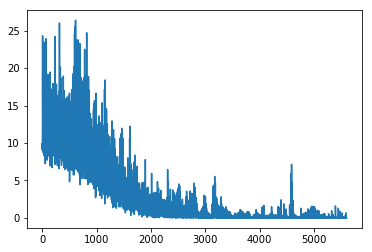

In [28]:
plt.figure()
plt.plot(loss_history)